# Cargar y preprocesar imágenes

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.keras import layers
from tensorflow.python.keras import regularizers
import keras_tuner as kt
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import pandas as pd


IMAGE_SIZE = 180
BATCH_SIZE = 32
CHANNELS = 3 # todavia no se que es esto
EPOCHS = 50 # ya se vera cual es el numero correcto // habia que hacer un rico for para ver que numero es

## Separamos las fotos en imagenes de entrenamiento (80%) y validación (20%) 

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "../../Aves v2",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  "../../Aves v2",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 58388 files belonging to 400 classes.
Using 46711 files for training.
Found 58388 files belonging to 400 classes.
Using 11677 files for validation.


In [3]:
class_names = train_ds.class_names
indices = np.arange(len(class_names))
num_classes = len(class_names)
class_names

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'AMETHYST WOODSTAR',
 'ANDEAN GOOSE',
 'ANDEAN LAPWING',
 'ANDEAN SISKIN',
 'ANHINGA',
 'ANIANIAU',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ANTILLEAN EUPHONIA',
 'APAPANE',
 'APOSTLEBIRD',
 'ARARIPE MANAKIN',
 'ASHY THRUSHBIRD',
 'ASIAN CRESTED IBIS',
 'AVADAVAT',
 'AZURE JAY',
 'AZURE TANAGER',
 'AZURE TIT',
 'BAIKAL TEAL',
 'BALD EAGLE',
 'BALD IBIS',
 'BALI STARLING',
 'BALTIMORE ORIOLE',
 'BANANAQUIT',
 'BAND TAILED GUAN',
 'BANDED BROADBILL',
 'BANDED PITA',
 'BANDED STILT',
 'BAR-TAILED GODWIT',
 'BARN OWL',
 'BARN SWALLOW',
 'BARRED PUFFBIRD',
 'BARROWS GOLDENEYE',
 'BAY-B

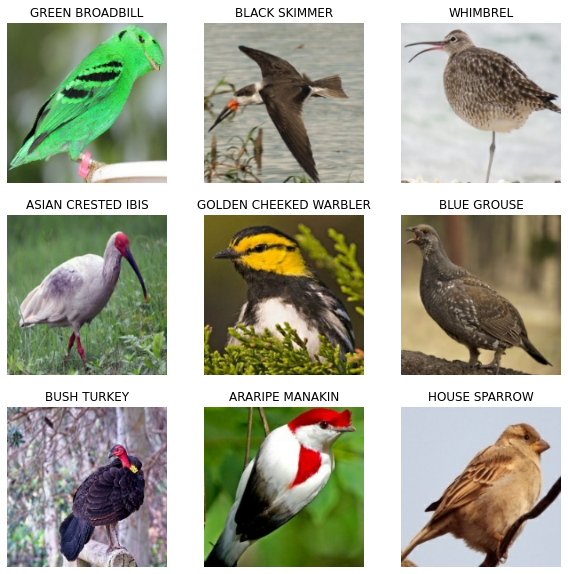

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
# poner graficos pie chart

## Configurar el conjunto de datos para el rendimiento

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Estandarización de datos
#### Actualmente las fotos estan en el rango RGB de [0, 255]. Esto no es ideal para una red neuronal, por eso hay que buscar que los valores de entrada sean mas pequeños

In [7]:
rescale_and_resize = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
])

## Aumento de datos
#### El aumento de datos se hace cuando no se tiene muchos datos, ademas ayuda a corregir el overfitting

In [8]:
data_augmentation = tf.keras.Sequential([
	tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
	tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
	tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

In [9]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#   for i in range(9):
#     augmented_images = data_augmentation(images)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[0].numpy().astype("uint8"))
#     plt.axis("off")

## Creación del modelo CNN

In [10]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = tf.keras.Sequential([
    rescale_and_resize,
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'), 
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(4069, activation='relu'),
    layers.Dropout(0.5), # ayuda a corregir el overfitting lo de quitar algunas redes neuronales
    layers.Dense(4069, activation='relu'),
    layers.Dropout(0.5), # ayuda a corregir el overfitting lo de quitar algunas redes neuronales
    layers.Dense(num_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 180, 180, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 180, 180, 3)         0         
                                                                 
 module_wrapper (ModuleWrapp  (32, 180, 180, 16)       448       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (32, 90, 90, 16)         0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (32, 90, 90, 32)         4640      
 pper)                                                           
                                                      

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [13]:
checkpointer = ModelCheckpoint(filepath='saved_models/modelo_dataset_2.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True) # que si ha mejorado el modelo lo guarde
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks=[early_stopping]

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

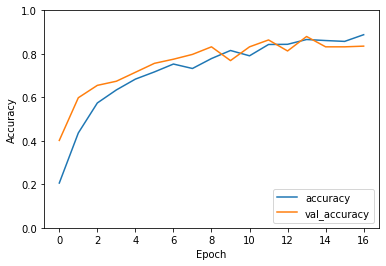

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


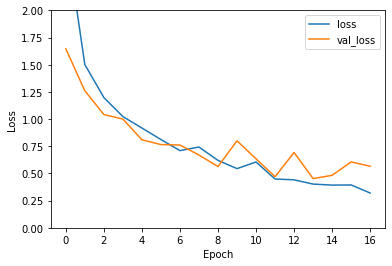

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')

In [ ]:
score1 = model.evaluate(val_ds, verbose=1)

10/10 [==============================] - 2s 177ms/step - loss: 0.5662 - accuracy: 0.8354


In [ ]:
model_version = 1
model.save_weights('saved_models/nuestro_modelo.h5')